In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from datetime import datetime
from scipy import stats

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
set_seeds()

## Data Loading and Preprocessing

In [2]:
def load_data(file_path):
    """Load data from parquet file."""
    data = pd.read_parquet(file_path)
    data = data.dropna(subset=['rain', 'wind'])
    return data

def split_data(data, train_years, val_year, test_year):
    """Split data into train, validation and test sets based on years."""
    data['time_bucket'] = pd.to_datetime(data['time_bucket'])
    
    train_data = data[data['time_bucket'].dt.year.isin(train_years)]
    val_data = data[data['time_bucket'].dt.year == val_year]
    test_data = data[data['time_bucket'].dt.year == test_year]
    
    print(f"Train data size: {len(train_data)}")
    print(f"Validation data size: {len(val_data)}")
    print(f"Test data size: {len(test_data)}")
    
    return train_data, val_data, test_data

def filter_ride_data(data, ride_name):
    """Filter data for a specific ride."""
    return data[data[f'ride_name_{ride_name}'] == True].copy()

In [3]:
# Load the data
data = load_data("../data/processed/ep/final_cleaned_processed_wait_times.parquet")
data

,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,...,season_summer,season_winter,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,0.0,0,18.7,0.0,1.1,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,18.7,0.0,1.1,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,18.7,0.0,1.1,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,18.7,0.0,1.1,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,18.7,0.0,1.1,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904291,20.0,0,-0.2,0.0,1.6,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904292,20.0,0,-0.2,0.0,1.6,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904293,5.0,0,-0.2,0.0,1.6,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904294,0.0,0,-0.2,0.0,1.6,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
# Define time periods for splitting
train_years, val_year, test_year = list(range(2017, 2023)), 2023, 2024

# Split the data
train_data, val_data, test_data = split_data(data, train_years, val_year, test_year)

Train data size: 516849
Validation data size: 126627
Test data size: 114101


In [5]:
# Filter for a specific ride
ride_name = "silver star"
ride_data = filter_ride_data(train_data, ride_name)
ride_data

,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,...,season_summer,season_winter,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
2,0.0,0,18.7,0.00,1.1,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,10.0,0,18.7,0.00,1.1,0,0,0,2017-05-23 09:30:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,10.0,0,21.5,0.00,0.7,0,0,0,2017-05-23 10:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,25.0,0,21.5,0.00,0.7,0,0,0,2017-05-23 10:30:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,15.0,0,23.8,0.00,1.8,0,0,0,2017-05-23 11:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662949,25.0,0,19.0,0.01,4.7,0,0,0,2022-12-31 14:30:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
662986,25.0,0,18.8,0.01,4.4,0,0,0,2022-12-31 15:00:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
663005,25.0,0,18.8,0.01,4.4,0,0,0,2022-12-31 15:30:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
663087,35.0,0,16.8,0.02,4.5,0,0,0,2022-12-31 17:00:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Time Series Decomposition with Prophet (Modified to exclude holidays)

In [6]:
class BaseTimeSeriesModel:
    """Class to handle basic Prophet time series modeling without holidays."""
    
    def __init__(self):
        self.model = None
        self.forecast = None
        
    def is_operating_month(self, ds):
        month = ds.month
        return 1 if (month >= 4 and month <= 12) else 0

    def prepare_prophet_dataframe(self, data):
        """Prepare data for Prophet."""
        prophet_df = data[['time_bucket', 'wait_time']].copy()
        prophet_df = prophet_df.rename(columns={'time_bucket': 'ds', 'wait_time': 'y'})
        prophet_df['operating_month'] = prophet_df['ds'].apply(self.is_operating_month)
        return prophet_df
    
    def fit(self, prophet_df):
        """Fit the Prophet model without using holidays."""
        # Create a Prophet model without holidays
        self.model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True,
            interval_width=0.95
        )
        
        # Define custom seasonality for operating months (April-December)
        self.model.add_seasonality(
            name='operating_season', 
            period=274,  # 9 months period
            fourier_order=9,
            condition_name='operating_month'
        )
        
        # Add COVID period as regressors instead of holidays
        prophet_df['during_covid_era'] = 0
        covid_period = (prophet_df['ds'] >= '2020-04-15') & (prophet_df['ds'] <= '2020-05-20')
        prophet_df.loc[covid_period, 'during_covid_era'] = 1
        self.model.add_regressor('during_covid_era')
        
        prophet_df['covid_recovery'] = 0
        recovery_period = (prophet_df['ds'] >= '2021-05-21') & (prophet_df['ds'] <= '2021-08-31')
        prophet_df.loc[recovery_period, 'covid_recovery'] = 1
        self.model.add_regressor('covid_recovery')

        self.model.fit(prophet_df)
        return self.model

    def predict(self, future_df):
        """Generate predictions with the fitted model."""
        # Add required columns for prediction
        future_df = future_df.copy()
        future_df['operating_month'] = future_df['ds'].apply(self.is_operating_month)
        
        # Add COVID regressors if they're not already present
        if 'during_covid_era' not in future_df.columns:
            future_df['during_covid_era'] = 0
            covid_period = (future_df['ds'] >= '2020-04-15') & (future_df['ds'] <= '2020-05-20')
            future_df.loc[covid_period, 'during_covid_era'] = 1
            
        if 'covid_recovery' not in future_df.columns:
            future_df['covid_recovery'] = 0
            recovery_period = (future_df['ds'] >= '2021-05-21') & (future_df['ds'] <= '2021-08-31')
            future_df.loc[recovery_period, 'covid_recovery'] = 1
        
        self.forecast = self.model.predict(future_df)
        return self.forecast
    
    def merge_predictions(self, original_data, forecast_data):
        """Merge original data with forecasts and calculate residuals."""
        result = original_data.copy()
        
        # Identify forecast columns to keep (exclude holiday components since we're not using them)
        forecast_columns = ['ds', 'trend', 'operating_season', 'weekly', 'daily', 'yhat']
        available_columns = [col for col in forecast_columns if col in forecast_data.columns]
        
        result = pd.merge(
            result, 
            forecast_data[available_columns], 
            left_on='time_bucket', 
            right_on='ds', 
            how='left'
        )
        
        result['residual'] = result['wait_time'] - result['yhat']
        return result

## Feature Engineering (With holidays for residual model)

In [7]:
class FeatureEngineer:
    """Class to handle feature engineering for the wait time prediction model."""
    
    @staticmethod
    def prepare_features(ride_data_df, forecast_df):
        """
        Prepare features for the neural network model.
        
        Parameters:
        -----------
        ride_data_df : pandas.DataFrame
            DataFrame containing ride data
        forecast_df : pandas.DataFrame
            DataFrame containing Prophet forecasts
            
        Returns:
        --------
        numpy.ndarray
            Array of features for the neural network
        """
        # Extract weather features
        weather_features = ride_data_df[['temperature', 'rain']].values
        
        # Extract holiday features (used only in the residual model)
        holiday_features = ride_data_df[
            ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
        ].astype(float).values

        # Extract time features
        timestamps = pd.to_datetime(ride_data_df['time_bucket'])
        time_features = FeatureEngineer._create_cyclical_time_features(timestamps)
        
        # Add prophet components as features
        prophet_features = []
        for component in ['trend', 'operating_season', 'weekly', 'daily']:
            if component in forecast_df.columns:
                # Merge the component from forecast_df to ride_data_df based on time_bucket/ds
                component_values = pd.merge(
                    ride_data_df[['time_bucket']], 
                    forecast_df[['ds', component]], 
                    left_on='time_bucket', 
                    right_on='ds', 
                    how='left'
                )[component].values.reshape(-1, 1)
                prophet_features.append(component_values)
        
        if prophet_features:
            prophet_features = np.hstack(prophet_features)
        else:
            # If no prophet features are available, create a placeholder column of zeros
            prophet_features = np.zeros((len(ride_data_df), 1))

        # Combine all features
        features = np.hstack([weather_features, holiday_features, time_features, prophet_features])
        return features
    
    @staticmethod
    def _create_cyclical_time_features(timestamps):
        """
        Create cyclical time features from timestamps.
        
        Parameters:
        -----------
        timestamps : pandas.Series
            Series of timestamps
            
        Returns:
        --------
        numpy.ndarray
            Array of cyclical time features
        """
        # Extract time components
        hour = timestamps.dt.hour
        day_of_week = timestamps.dt.dayofweek
        month = timestamps.dt.month
        day_of_year = timestamps.dt.dayofyear

        # Create cyclical features
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        dow_sin = np.sin(2 * np.pi * day_of_week / 7)
        dow_cos = np.cos(2 * np.pi * day_of_week / 7)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        doy_sin = np.sin(2 * np.pi * day_of_year / 365.25)
        doy_cos = np.cos(2 * np.pi * day_of_year / 365.25)

        # Stack all cyclical features
        cyclical_features = np.column_stack([
            hour_sin, hour_cos, 
            dow_sin, dow_cos,
            month_sin, month_cos,
            doy_sin, doy_cos
        ])
        
        return cyclical_features

## Neural Network Model

In [8]:
class RideDataset(Dataset):
    """PyTorch Dataset for ride wait time data."""
    
    def __init__(self, features, targets, scaler=None):
        """
        Initialize the dataset.
        
        Parameters:
        -----------
        features : numpy.ndarray
            Array of features
        targets : numpy.ndarray
            Array of target values
        scaler : StandardScaler, optional
            Scaler for features
        """
        if scaler is None:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(features)
        else:
            self.scaler = scaler
            self.features = self.scaler.transform(features)
            
        self.targets = torch.tensor(targets, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        # Handle NaN values
        features = np.nan_to_num(self.features[idx])
        targets = np.nan_to_num(self.targets[idx])

        return torch.tensor(features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [9]:
class ResidualPredictor(nn.Module):
    """Neural network model for predicting residuals."""
    
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_prob=0.2):
        super(ResidualPredictor, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

In [10]:
class ModelTrainer:
    """Class to handle model training and evaluation."""
        
    @staticmethod
    def train_nn_model(train_features, train_residuals, val_features, val_residuals, num_epochs=50,
                      hidden_dims=[128, 64], dropout_prob=0.2, 
                      batch_size=512, patience=10, device='cpu'):
        """
        Train the neural network model.
        
        Parameters:
        -----------
        train_features : numpy.ndarray
            Training features
        train_residuals : numpy.ndarray
            Training targets (residuals)
        val_features : numpy.ndarray
            Validation features
        val_residuals : numpy.ndarray
            Validation targets (residuals)
        num_epochs : int
            Number of training epochs
        hidden_dims : list
            List of hidden layer dimensions
        dropout_prob : float
            Dropout probability
        batch_size : int
            Batch size for training
        patience : int
            Number of epochs to wait for improvement before early stopping
        device : str
            Device to use for training ('cpu' or 'cuda')
            
        Returns:
        --------
        tuple
            Trained neural network model and feature scaler
        """
        # Create datasets and dataloaders
        train_dataset = RideDataset(train_features, train_residuals)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        feature_scaler = train_dataset.scaler

        val_dataset = RideDataset(val_features, val_residuals, scaler=feature_scaler)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_dim = train_features.shape[1]
        model = ResidualPredictor(input_dim, hidden_dims=hidden_dims, dropout_prob=dropout_prob)
        model.to(device)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # Training loop parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None

        # Training loop with tqdm progress bar
        pbar = tqdm(range(num_epochs), desc="Training")
        for epoch in pbar:
            # Training phase
            model.train()
            running_loss = 0.0
            
            for batch_features, batch_residuals in train_dataloader:
                batch_features = batch_features.to(device)
                batch_residuals = batch_residuals.to(device)

                # Forward and backward passes
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_residuals)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_loss = running_loss / len(train_dataloader)

            # Validation phase
            val_loss = float('inf')
            if val_dataloader:
                model.eval()
                val_running_loss = 0.0
                
                with torch.no_grad():
                    for val_features_batch, val_residuals_batch in val_dataloader:
                        val_features_batch = val_features_batch.to(device)
                        val_residuals_batch = val_residuals_batch.to(device)

                        val_outputs = model(val_features_batch)
                        val_loss_batch = criterion(val_outputs, val_residuals_batch)
                        val_running_loss += val_loss_batch.item()
                
                val_loss = val_running_loss / len(val_dataloader)
                scheduler.step(val_loss)

                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    best_model_state = model.state_dict().copy()
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        pbar.set_description(f"Early stopping at epoch {epoch+1}")
                        model.load_state_dict(best_model_state)
                        break

            # Update tqdm postfix with loss values
            pbar.set_postfix({'train_loss': f'{train_loss:.4f}', 'val_loss': f'{val_loss:.4f}'})
        
        # Load best model state if available
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        return model, feature_scaler

In [11]:
class WaitTimePredictor:
    """Class to combine Prophet and Neural Network predictions."""
    
    @staticmethod
    def batch_predict(ride_df, prophet_model, nn_model, feature_scaler, 
                    feature_engineer, device='cpu'):
        """
        Efficient batch prediction for wait times.
        
        Parameters:
        -----------
        ride_df : pandas.DataFrame
            DataFrame containing ride data
        prophet_model : Prophet
            Trained Prophet model
        nn_model : ResidualPredictor
            Trained neural network model
        feature_scaler : StandardScaler
            Feature scaler used during training
        feature_engineer : FeatureEngineer
            Feature engineering class
        device : str
            Device to use for prediction ('cpu' or 'cuda')
            
        Returns:
        --------
        numpy.ndarray
            Array of predicted wait times
        """
        # Get Prophet forecasts for all timestamps
        timestamps_df = pd.DataFrame({'ds': ride_df['time_bucket'].unique()})
        timestamps_df['operating_month'] = timestamps_df['ds'].apply(
            lambda x: 1 if (x.month >= 4 and x.month <= 12) else 0
        )
        
        # Add COVID regressors
        timestamps_df['during_covid_era'] = 0
        covid_period = (timestamps_df['ds'] >= '2020-04-15') & (timestamps_df['ds'] <= '2020-05-20')
        timestamps_df.loc[covid_period, 'during_covid_era'] = 1
        
        timestamps_df['covid_recovery'] = 0
        recovery_period = (timestamps_df['ds'] >= '2021-05-21') & (timestamps_df['ds'] <= '2021-08-31')
        timestamps_df.loc[recovery_period, 'covid_recovery'] = 1
        
        # Get Prophet forecasts
        prophet_forecasts = prophet_model.predict(timestamps_df)
        
        # Merge prophet forecasts with the original data
        ride_data_with_forecast = pd.merge(
            ride_df,
            prophet_forecasts[['ds', 'yhat', 'trend', 'operating_season', 'weekly', 'daily']],
            left_on='time_bucket', 
            right_on='ds',
            how='left'
        )
        
        # Generate features for neural network
        features = feature_engineer.prepare_features(ride_data_with_forecast, prophet_forecasts)
        
        # Scale features
        scaled_features = feature_scaler.transform(features)
        features_tensor = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        
        # Get residual predictions from neural network
        nn_model.eval()
        with torch.no_grad():
            residuals = nn_model(features_tensor).cpu().numpy().flatten()
        
        # Combine predictions
        final_predictions = ride_data_with_forecast['yhat'].values + residuals
        
        # Ensure non-negative wait times
        final_predictions = np.maximum(0, final_predictions)
        
        return final_predictions, ride_data_with_forecast['yhat'].values, residuals

## Main Script Execution

In [12]:
# Initialize and train the Prophet model (without holidays)
prophet_ts = BaseTimeSeriesModel()
prophet_df = prophet_ts.prepare_prophet_dataframe(ride_data)
prophet_model = prophet_ts.fit(prophet_df)

18:14:25 - cmdstanpy - INFO - Chain [1] start processing
18:14:31 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Generate future dataframe for prediction
future = pd.DataFrame({'ds': ride_data['time_bucket'].unique()})
train_forecast = prophet_ts.predict(future)

In [14]:
# Merge predictions with original data
result = prophet_ts.merge_predictions(ride_data, train_forecast)

In [15]:
# Prepare features for training the neural network
feature_engineer = FeatureEngineer()
train_features = feature_engineer.prepare_features(ride_data, train_forecast)
train_residuals = result['residual'].values

## Validation Preparation

In [16]:
# Prepare validation data
ride_val_data = filter_ride_data(val_data, ride_name)

# Prepare validation timestamps for Prophet
val_dates = pd.DataFrame({'ds': ride_val_data['time_bucket'].unique()})
val_dates['operating_month'] = val_dates['ds'].apply(
    lambda x: 1 if (x.month >= 4 and x.month <= 12) else 0
)

# Add COVID regressors
val_dates['during_covid_era'] = 0
val_dates['covid_recovery'] = 0

# Get Prophet forecasts for validation
val_forecast = prophet_ts.predict(val_dates)

# Merge validation data with forecasts
ride_val_data_with_forecast = pd.merge(
    ride_val_data,
    val_forecast[['ds', 'yhat', 'trend', 'operating_season', 'weekly', 'daily']],
    left_on='time_bucket', 
    right_on='ds',
    how='left'
)

ride_val_data_with_forecast['residual'] = ride_val_data_with_forecast['wait_time'] - ride_val_data_with_forecast['yhat']

In [17]:
# Prepare validation features
val_features = feature_engineer.prepare_features(ride_val_data_with_forecast, val_forecast)
val_residuals = ride_val_data_with_forecast['residual'].values

## Neural Network Training

In [18]:
# Train the neural network model with improved parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_model, feature_scaler = ModelTrainer.train_nn_model(
    train_features, train_residuals, 
    val_features, val_residuals,
    num_epochs=50,  # Increased from 20
    hidden_dims=[128, 64, 32],  # Added an extra layer
    dropout_prob=0.2,  # Reduced from 0.4
    batch_size=512,
    patience=10,  # Reduced from 20 to match with increased epochs
    device=device
)

Early stopping at epoch 22:  42%|████▏     | 21/50 [00:33<00:46,  1.60s/it, train_loss=63.9107, val_loss=169.5253]


## Model Evaluation

In [19]:
# Evaluate on validation set using batch prediction
val_predictions, baseline_predictions, residual_predictions = WaitTimePredictor.batch_predict(
    ride_val_data, 
    prophet_model, 
    nn_model, 
    feature_scaler,
    feature_engineer,
    device
)

val_actuals = ride_val_data['wait_time'].values

In [20]:
# Calculate validation metrics
val_mae = np.mean(np.abs(val_predictions - val_actuals))
val_rmse = np.sqrt(np.mean(np.square(val_predictions - val_actuals)))

# Calculate baseline metrics (Prophet only)
baseline_mae = np.mean(np.abs(baseline_predictions - val_actuals))
baseline_rmse = np.sqrt(np.mean(np.square(baseline_predictions - val_actuals)))

print(f"Validation MAE: {val_mae:.2f} minutes (Baseline: {baseline_mae:.2f})")
print(f"Validation RMSE: {val_rmse:.2f} minutes (Baseline: {baseline_rmse:.2f})")

Validation MAE: 8.90 minutes (Baseline: 10.72)
Validation RMSE: 11.39 minutes (Baseline: 13.29)


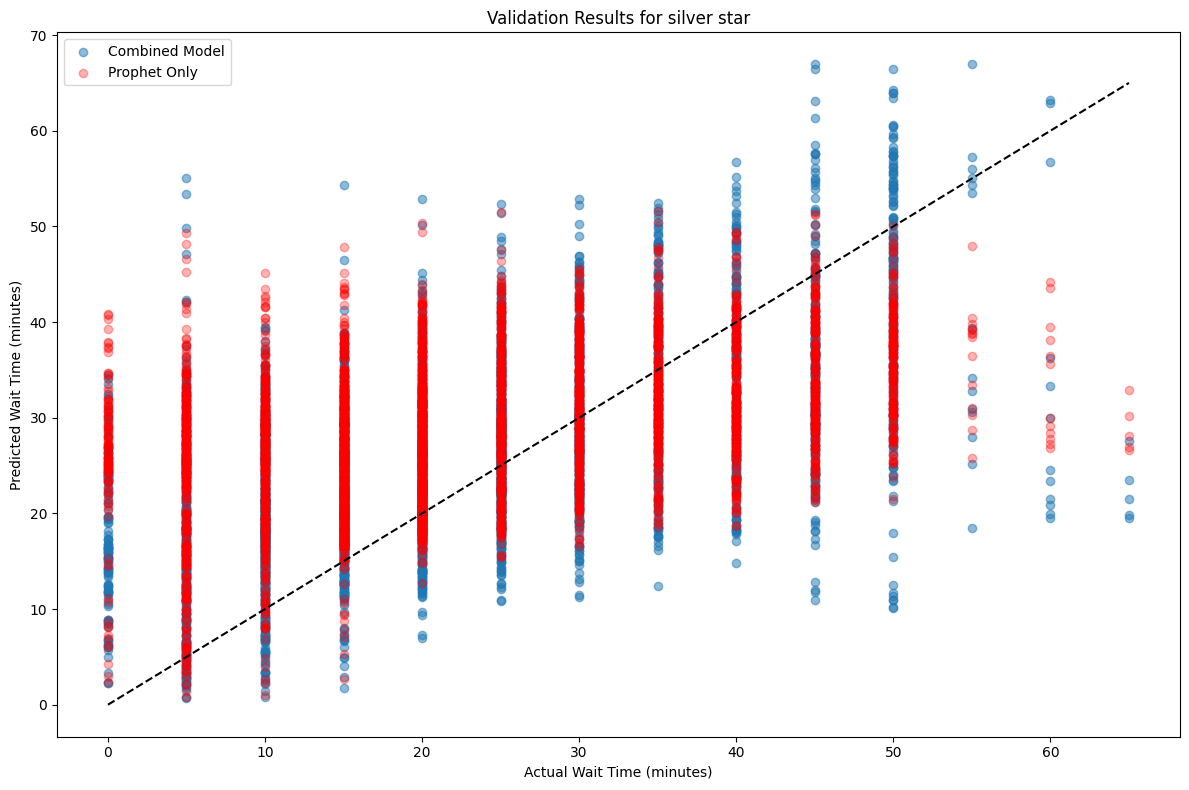

In [21]:
# Visualize results
fig, ax = plt.subplots(figsize=(12, 8))

# Plot actual vs predicted scatter
ax.scatter(val_actuals, val_predictions, alpha=0.5, label='Combined Model')
ax.scatter(val_actuals, baseline_predictions, alpha=0.3, color='red', label='Prophet Only')

# Plot perfect prediction line
ax.plot([0, max(val_actuals)], [0, max(val_actuals)], 'k--')

# Add labels and title
ax.set_xlabel('Actual Wait Time (minutes)')
ax.set_ylabel('Predicted Wait Time (minutes)')
ax.set_title(f'Validation Results for {ride_name}')
ax.legend()

plt.tight_layout()
plt.show()

## Time-Based Analysis

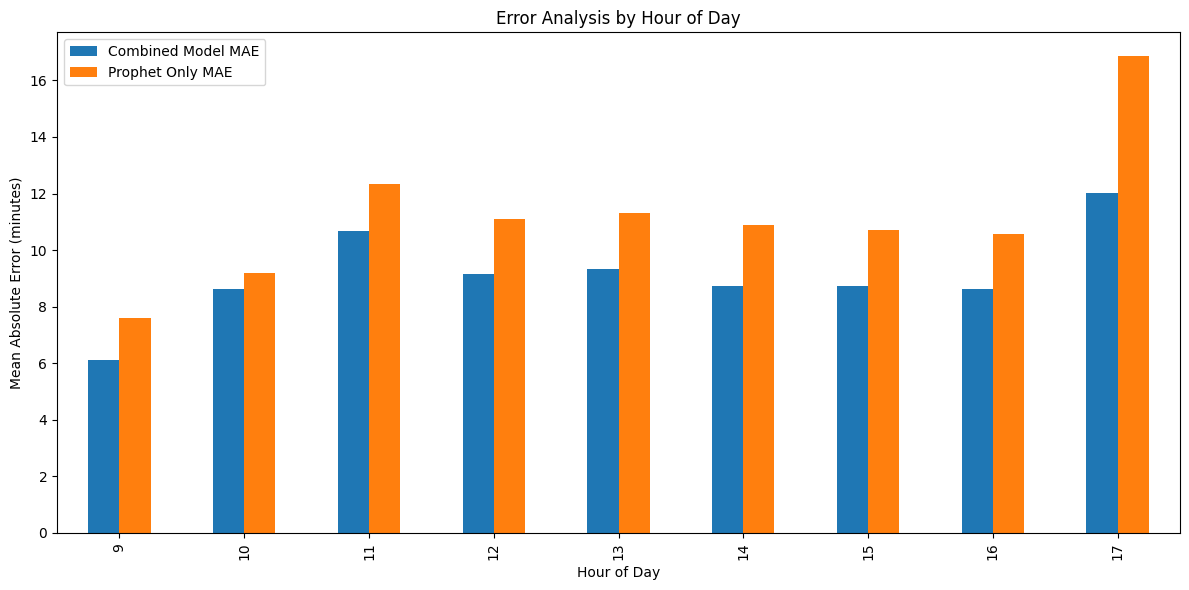

In [22]:
# Create a DataFrame with validation results for time-based analysis
val_results = pd.DataFrame({
    'time_bucket': ride_val_data['time_bucket'].values,
    'actual': val_actuals,
    'predicted': val_predictions,
    'baseline': baseline_predictions,
    'residual_pred': residual_predictions
})

# Add time components
val_results['hour'] = val_results['time_bucket'].dt.hour
val_results['day_of_week'] = val_results['time_bucket'].dt.dayofweek
val_results['month'] = val_results['time_bucket'].dt.month

# Calculate errors
val_results['error'] = val_results['predicted'] - val_results['actual']
val_results['abs_error'] = np.abs(val_results['error'])
val_results['baseline_error'] = val_results['baseline'] - val_results['actual']
val_results['baseline_abs_error'] = np.abs(val_results['baseline_error'])

# Group by hour
hourly_errors = val_results.groupby('hour')[['abs_error', 'baseline_abs_error']].mean()
hourly_errors = hourly_errors.rename(columns={'abs_error': 'Combined Model MAE', 
                                             'baseline_abs_error': 'Prophet Only MAE'})

# Visualize hourly errors
fig, ax = plt.subplots(figsize=(12, 6))
hourly_errors.plot(kind='bar', ax=ax)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Absolute Error (minutes)')
ax.set_title('Error Analysis by Hour of Day')
plt.tight_layout()
plt.show()

# Done!